In [120]:
import Pkg
Pkg.activate(".")
using Lux, Metal, MLUtils, MultivariateStats, Optimisers, Random, Zygote, LossFunctions, ComponentArrays
using CairoMakie, Printf, Statistics, LinearAlgebra, HDF5

  Activating project at `~/Dropbox/research/sciml-tearfilms/julia`


Load synthetic data from files.

In [2]:
function load_data(files)
    function getmats(file)
        datastore = h5open(file, "r")
        I = read(datastore["I"])
        T = read(datastore["T"])
        c = read(datastore["c"])
        close(datastore)
        return I, T, c
    end
    mats = map(getmats, files)
    I = hcat([m[1] for m in mats]...)
    T = hcat([m[2] for m in mats]...)
    c = hcat([m[3] for m in mats]...)
    t = range(0, 1, size(I, 1))
    return t, (; I, T, c)
end

t, data = load_data(["/Users/driscoll/Dropbox/research/tearfilm/thermal/inverse/trials_many_alldata_v3.h5"]);
println("$(size(data.I, 2)) samples loaded");

111563 samples loaded


Examples of inputs and outputs:

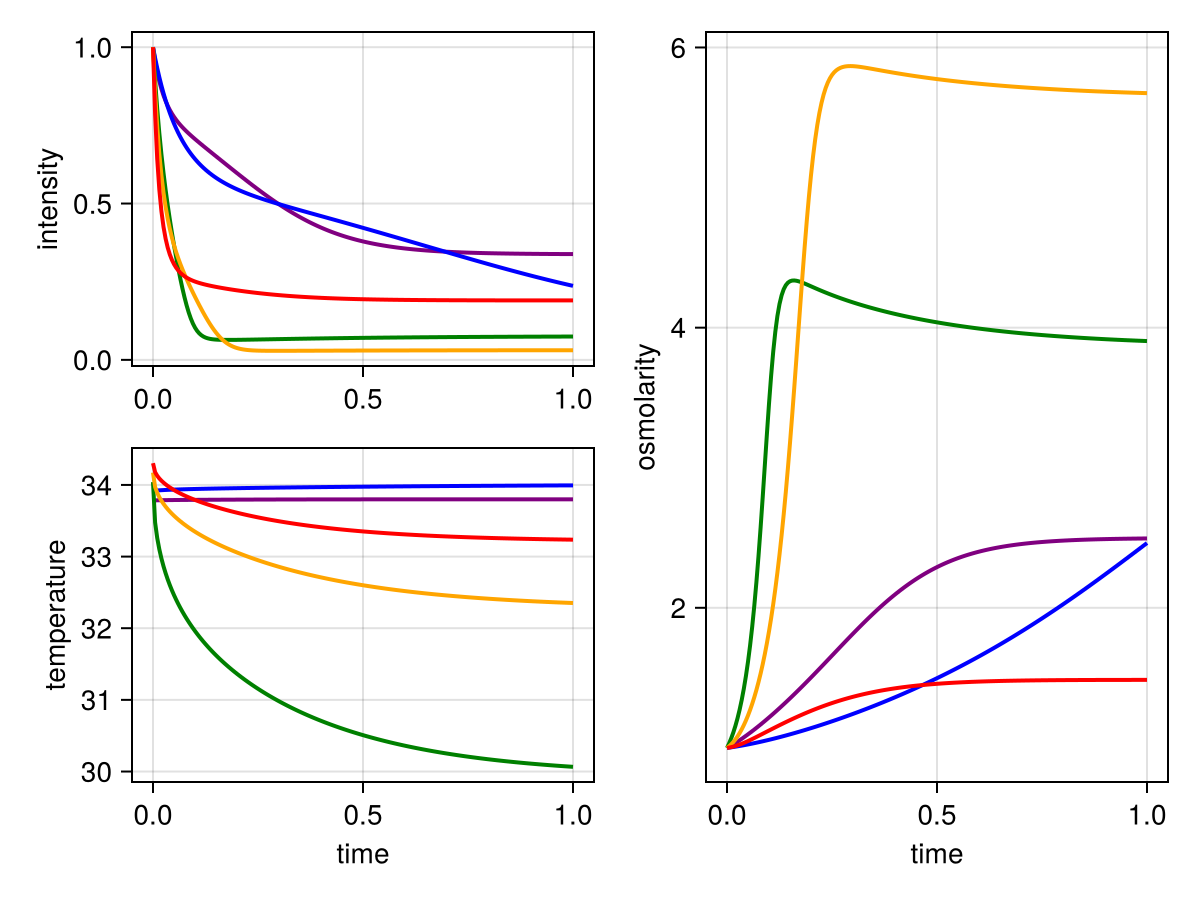

In [3]:
fig = Figure()
fig[1,1] = gr = GridLayout()
series(gr[1,1], t, data.I[:,1:5]', axis=(ylabel="intensity", ), color=:rainbow)
series(gr[2,1], t, data.T[:,1:5]', axis=(xlabel="time", ylabel="temperature"), color=:rainbow)
series(fig[1,2], t, data.c[:,1:5]', axis=(xlabel="time", ylabel="osmolarity"), color=:rainbow)
fig

Apply PCA to the input data and prepare for batch training.

In [10]:
function convert_data(data, batchsize, train_split=0.8)
    X = reshape([data.I; data.T], :, 2, size(data.I, 2))
    y = data.c
    (X_train, y_train), (X_test, y_test) = splitobs((X, y); at=train_split)
    return DataLoader(collect.((X_train, y_train)); batchsize, shuffle=true),
        DataLoader(collect.((X_test, y_test)); batchsize, shuffle=false)
end

train_loader, test_loader = convert_data(data, 1000);
dim_input = size(train_loader.data[1], 1)
dim_output = size(train_loader.data[2], 1)
println("input data has dimension $(dim_input)")
println("output data has dimension $(dim_output)")

input data has dimension 201
output data has dimension 201


Define a training loop.

In [11]:
function train(loss, model, ps, st, train_loader, test_loader; num_epochs=10, rate=0.005, kwargs...)
    train_state = Training.TrainState(model, ps, st, Adam(Float32(rate)))

    ### Warm up the model
    x, y = first(train_loader)
    Training.compute_gradients(AutoZygote(), loss, (x, y), train_state)

    ### Train the model
    tr_acc, te_acc = 0.0, 0.0
    for epoch in 1:num_epochs
        stime = time()
        for (x, y) in train_loader
            gs, _, _, train_state = Training.single_train_step!(
                AutoZygote(), loss, (x, y), train_state)
        end
        ttime = time() - stime

        tr_acc = accuracy(loss,
            model, train_state.parameters, train_state.states, train_loader)
        te_acc = accuracy(loss,
            model, train_state.parameters, train_state.states, test_loader)

        # @printf "[%2d/%2d] \t Time %.2fs \t Training loss: %.4g \t Test loss: \
                #  %.4g\n" epoch num_epochs ttime tr_acc te_acc
    end

    return tr_acc, te_acc
end

function accuracy(loss, model, ps, st, dataloader)
    tse, total = 0, 0
    st = Lux.testmode(st)
    for (x, y) in dataloader
        predicted = first(model(x, ps, st))
        n = size(x, 2)
        tse += n*loss(predicted, y)
        total += n
    end
    return tse / total
end

accuracy (generic function with 1 method)

Create a NN model.

In [131]:
Pkg.add("GPUArraysCore")

   Resolving package versions...
    Updating `~/Dropbox/research/sciml-tearfilms/julia/Project.toml`
  [46192b85] + GPUArraysCore v0.1.6
  No Changes to `~/Dropbox/research/sciml-tearfilms/julia/Manifest.toml`


In [134]:
model = Chain(
    Conv((5,), 2 => 8, relu),
    MaxPool((3,)),
    # Conv((5,), 8 => 16, relu),
    # MeanPool((3,)),
    # Conv((5,), 16 => 24, relu),
    # MeanPool((3,)),
    # FlattenLayer(),
    # Dense(160 => 256, relu),
    # # # Dense(256 => 256, relu),
    # Dense(256 => dim_output),
    )
using GPUArraysCore
GPUArraysCore.allowscalar(true)
# initialize the model parameters 
ps, st = Lux.setup(Xoshiro(0), model)
ps = ps |> dev
(x,y) = first(train_loader)
size(model(dev(x), ps, st)[1])

CompositeException: TaskFailedException

    nested task error: TaskFailedException
    
        nested task error: ArgumentError: cannot take the CPU address of a MtlArray{Float32, 5, Metal.PrivateStorage}
        Stacktrace:
         [1] unsafe_convert(::Type{Ptr{Float32}}, x::MtlArray{Float32, 5, Metal.PrivateStorage})
           @ Metal ~/.julia/packages/Metal/UcSBS/src/array.jl:264
         [2] unsafe_convert(::Type{Ptr{Float32}}, V::SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false})
           @ Base ./reshapedarray.jl:331
         [3] pointer(x::SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false})
           @ Base ./abstractarray.jl:1232
         [4] pointer
           @ ./abstractarray.jl:1235 [inlined]
         [5] (::NNlib.var"#612#613"{MtlArray{Float32, 3, Metal.PrivateStorage}, Float32, Float32, SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false}, SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false}, MtlArray{Float32, 5, Metal.PrivateStorage}, DenseConvDims{3, 3, 3, 6, 3}, Int64, Int64, Int64, UnitRange{Int64}, Int64})()
           @ NNlib ~/.julia/packages/NNlib/GBLuM/src/impl/conv_im2col.jl:58
    Stacktrace:
     [1] sync_end(c::Channel{Any})
       @ Base ./task.jl:466
     [2] macro expansion
       @ ./task.jl:499 [inlined]
     [3] conv_im2col!(y::SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false}, x::SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false}, w::MtlArray{Float32, 5, Metal.PrivateStorage}, cdims::DenseConvDims{3, 3, 3, 6, 3}; col::MtlArray{Float32, 3, Metal.PrivateStorage}, alpha::Float32, beta::Float32, ntasks::Int64)
       @ NNlib ~/.julia/packages/NNlib/GBLuM/src/impl/conv_im2col.jl:50
     [4] conv_im2col!
       @ ~/.julia/packages/NNlib/GBLuM/src/impl/conv_im2col.jl:23 [inlined]
     [5] (::NNlib.var"#284#288"{@Kwargs{}, DenseConvDims{3, 3, 3, 6, 3}, SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false}, MtlArray{Float32, 5, Metal.PrivateStorage}, SubArray{Float32, 5, MtlArray{Float32, 5, Metal.PrivateStorage}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false}})()
       @ NNlib ~/.julia/packages/NNlib/GBLuM/src/conv.jl:209

In [56]:
model = Chain(
    Conv((5,), 2 => 24, relu),
    MaxPool((3,)),
    Conv((5,), 24 => 24, relu),
    MaxPool((3,)),
    Conv((5,), 24 => 24, relu),
    MaxPool((3,)),
    FlattenLayer(),
    # Dense(160 => 256, relu),
    Dense(120 => dim_output),
    )

# initialize the model parameters 
ps, st = Lux.setup(Xoshiro(0), model)

loss = MSELoss();

In [111]:
dev = gpu_device()
# @allowscalar

(::MetalDevice) (generic function with 5 methods)

Run training.

In [106]:
train_acc, test_acc = train(loss, model, dev(ps), dev(st), dev(train_loader), dev(test_loader); num_epochs=300, rate=0.0005)


(0.23907231f0, 0.24026923f0)

Find predictions over all the test data.

In [107]:
c_pred = hcat([first(model(x, ps, st)) for (x, _) in test_loader]...);
c_true = hcat([y for (_, y) in test_loader]...);

Look at a few comparisons.

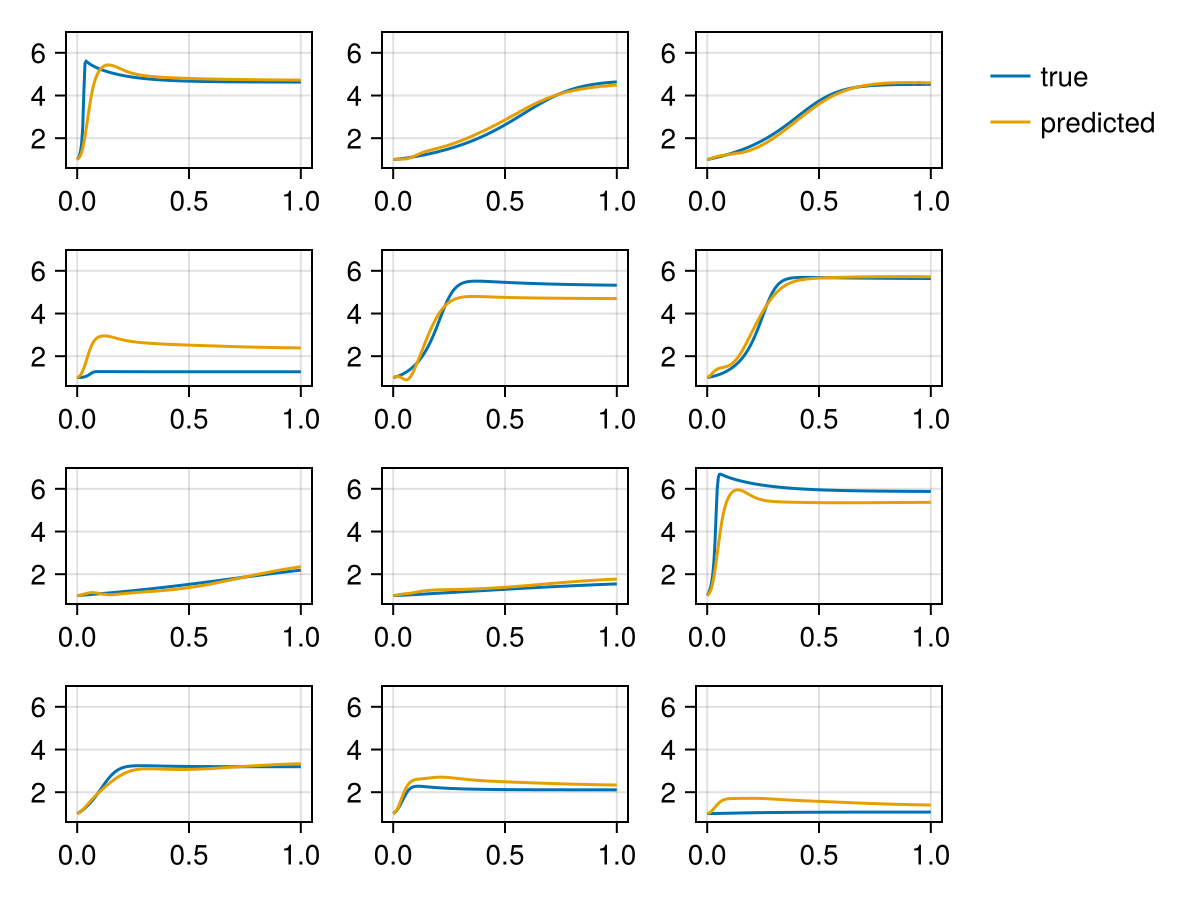

In [108]:
fig = Figure()
grid = CartesianIndices((1:4, 1:3))
for (k, idx) in enumerate(grid)
    lines(fig[idx[1],idx[2]], t, c_true[:, k], label="true")
    lines!(t, c_pred[:, k], label="predicted")
end
linkyaxes!(fig.content...)
Legend(fig[1, 4], fig.content[1], framevisible=false)
fig

Find the L2-norms of the differences.

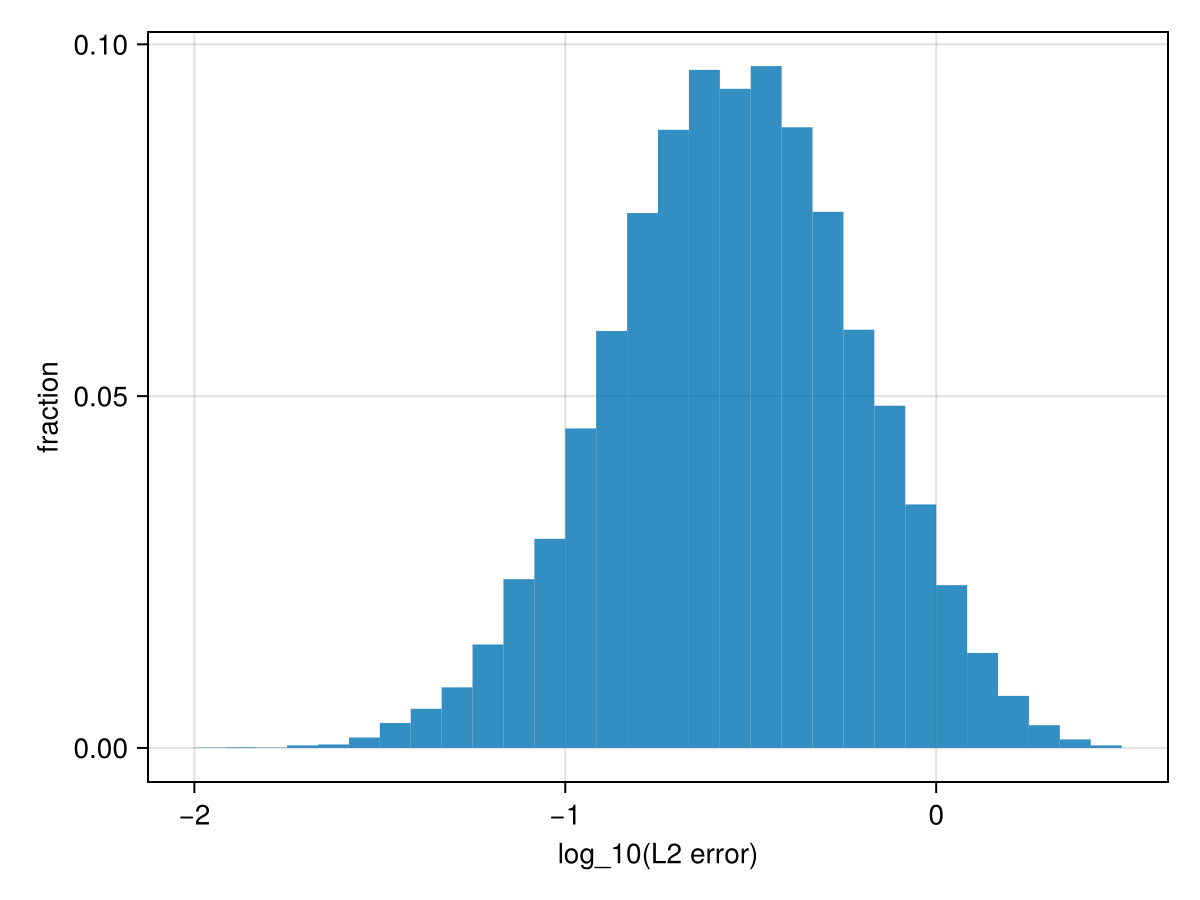

In [109]:
norm_diff = map(norm, eachcol(c_pred - c_true)) / sqrt(length(t) - 1)
fig, ax, _ = hist(log10.(norm_diff), bins=range(-2, 0.5, 31), normalization=:probability)
ax.xlabel = "log_10(L2 error)"
ax.ylabel = "fraction"
fig